# Notebook 0: Unconditional Variational Diffusion Models

In this notebook, we will implement a variational diffusion model from scratch to generate MNIST digits. This will give you important context for the lecture, as it will allow you to connect the mathematical concepts with code. This notebook has only one external dependency and can be run on a CPU Colab instance, but it will be **much** faster it you run it on a GPU instance. To activate a free GPU instance, go to `Runtime`$\to$ `Change Runtime Type` and select a GPU runtime.

We will first install the only dependency, `deepinv`, which we will only use to get access to a premade model architecture (the famed [UNet](https://arxiv.org/abs/1505.04597)). We will mention this architecture in the lecture. If you have time, you could try implementing the UNet from scratch, or you can just look at the code [here](https://github.com/deepinv/deepinv/blob/main/deepinv/models/unet.py).

Note: This tutorial is based on [this repository](https://github.com/ytdeepia/DDPM/tree/main), re-used under the terms of the MIT License.

In [1]:
%%capture
!pip install deepinv

**IMPORTANT**: Please make sure to restart your session (`Runtime` $\to$ `Restart Session`) before proceeding.

We require a bit of PyTorch boilerplate to get started, and we will import the model architecture that is used below.

In [1]:
import torch
import deepinv
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm.notebook import trange
from pathlib import Path
import os
from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
BS = 1024 #batch size, decrease if you are hitting memory limits
IS = 32 #image size (square)
LR = 1e-4 #learning rate
NUM_EPOCHS = 100

Using device: cuda


Next, we will establish a pipeline to load MNIST digits, resize them to $32 \times 32$ and normalise them to $[0,1]$.

In [2]:
transform = transforms.Compose(
    [
        transforms.Resize(IS),
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,)),
    ]
)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=BS,
    shuffle=True,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.54MB/s]


We will learn exactly how diffusion models work in the lecture. For now, it is enough to gain the following intuition:
- To train a diffusion model, we add noise to an image until it is no longer recognisable as an image
- We then train a model to *undo* that noise addition. This *denoising* problem is cast as a regression task in image space: Given the noisy image, predict the noise that needs to be subtracted to get a clean image.

First, we will instantiate the model architecture that is used to denoise the images. In the lecture, we will learn that the UNet's job is to **predict the random noise** that is added to the image. Essentially, the UNet performs a simple noise regression task: We input a noisy image and the UNet learns to separate the noise from the input and predict just the noise. For this, we use the Mean Squared Error (MSE) loss between the true added noise and the predicted added noise.

In [8]:
model = deepinv.models.DiffUNet(in_channels=1, out_channels=1, pretrained=None).to(
    device
)
optim = torch.optim.Adam(model.parameters(), lr=LR)
criterion = deepinv.loss.MSE(reduction="mean")

This gives us the first important component of a diffusion pipeline: **The UNet.**

Next, we need another important component, the **noise scheduler**. You can think of this as a sequence of noise scales that we add to the input images so that the UNet learns to deal with various levels of random noise.

There are various types of noise schedulers, but we will use the simplest one: A linearly spaced noise schedule. It is important to understand that, although the noise increases step by step, we need to be careful that the total added noise does not explode, so we will make sure that the total noise variance tends towards 1 as we approach the end of training. This will be explained in the lecture.

Note the distinction between the noise schedule (which is linear) and the resulting actual noise variance, which increases like a square root.

There are other noise schedulers (e.g., cosine), which you can experiment with in your own time by changing the `betas` variable below.

Text(0, 0.5, 'Total noise variance')

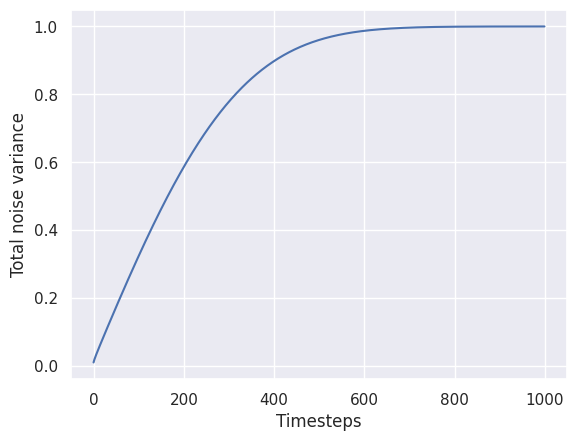

In [10]:
BETA_START = 1e-4
BETA_END = 0.02
TIMESTEPS = 1000

betas = torch.linspace(BETA_START, BETA_END, TIMESTEPS, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
plt.plot(range(TIMESTEPS), sqrt_one_minus_alphas_cumprod.detach().cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("Total noise variance")

As you can see, the noise increases linearly over time, but never becomes too large to avoid a variance explosion. In our lecture (and in the literature), the noise variance term is typically named $(1-\bar \alpha_t)$.

With this under our belts, we can now train the model. We have commented the steps below for you, and you will see the math in the lecture, but this is mostly just a regular PyTorch training loop.

Training this model takes quite long (around 1h on an A100 GPU), so we also provide an option to load a checkpoint.

In [10]:
for epoch in trange(NUM_EPOCHS):
    model.train()
    for data, _ in train_loader:
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, TIMESTEPS, (imgs.size(0),), device=device)

        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        ) #we will explain this term in the lecture, but think "noised image"
        # The model predicts the noise.
        # We will explain the importance of passing the time-step to the model in the lecture
        estimated_noise = model(noised_imgs, t, type_t="timestep")
        # Regression: We compare the noise prediction to the actual noise.
        loss = criterion(estimated_noise, noise)
        loss.backward()
        optim.step()
        optim.zero_grad(True)

torch.save(
   model.state_dict(),
   "trained_diffusion_model_large.pth",
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
checkpoint_path = "/content/trained_diffusion_model_large.pth"
model = deepinv.models.DiffUNet(in_channels=1, out_channels=1, pretrained=Path(checkpoint_path))

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint)
    print(f"Loaded model from {checkpoint_path}")
else:
    raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

model.to(device)
model.eval()
os.makedirs("./img/mnist_samples", exist_ok=True)

Loaded model from /content/trained_diffusion_model_large.pth


We can now use our trained diffusion model to generate fresh MNIST images.

In [18]:
def sample_ddpm(model, image_size=32, batch_size=4, channels=1):
    # Start from pure noise
    x = torch.randn(batch_size, channels, image_size, image_size).to(device)

    for t in tqdm(reversed(range(TIMESTEPS))):
        # The model is parameterised by the time step
        t_batch = torch.full((batch_size,), t, dtype=torch.long).to(device)
        with torch.no_grad():
            # Predict noise
            noise_pred = model(x, t_batch, type_t="timestep")
            # Sample from posterior, this will be discussed in the lecture
            alpha_t = alphas[t]
            alpha_cumprod_t = alphas_cumprod[t]
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            # Equation for x_{t-1} given x_t and predicted noise
            coef1 = 1.0 / torch.sqrt(alpha_t)
            coef2 = (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_cumprod_t)
            x = coef1 * (x - coef2 * noise_pred) + torch.sqrt(betas[t]) * noise

            # Save the intermediate sample at this timestep
            if t % 10 == 0:
                idx = 0
                for b in range(batch_size):
                    img = x[b, 0].cpu().detach().numpy()

                    img = (img - img.min()) / (
                        img.max() - img.min() + 1e-8
                    )
                    plt.imsave(
                        f"./img/mnist_samples/sample_{idx+b}_{t}.png", img, cmap="gray"
                    )

    x = torch.clamp(x, 0, 1)
    return x

def plot_tensor_grid(tensor):
    """
    Plots a PyTorch tensor of shape (8, 1, 32, 32) as a 2x4 grid of images.

    Args:
        tensor (torch.Tensor): The tensor to plot.
    """
    tensor = tensor.detach().cpu()  # Detach and move to CPU
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    axes = axes.flatten()
    for idx in range(8):
        img = tensor[idx, 0].numpy()
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
num_samples = 8
batch_size = 8
samples_list = []

for i in range(num_samples // batch_size):
    batch_samples = sample_ddpm(model, batch_size=batch_size)
    samples_list.append(batch_samples)

0it [00:00, ?it/s]

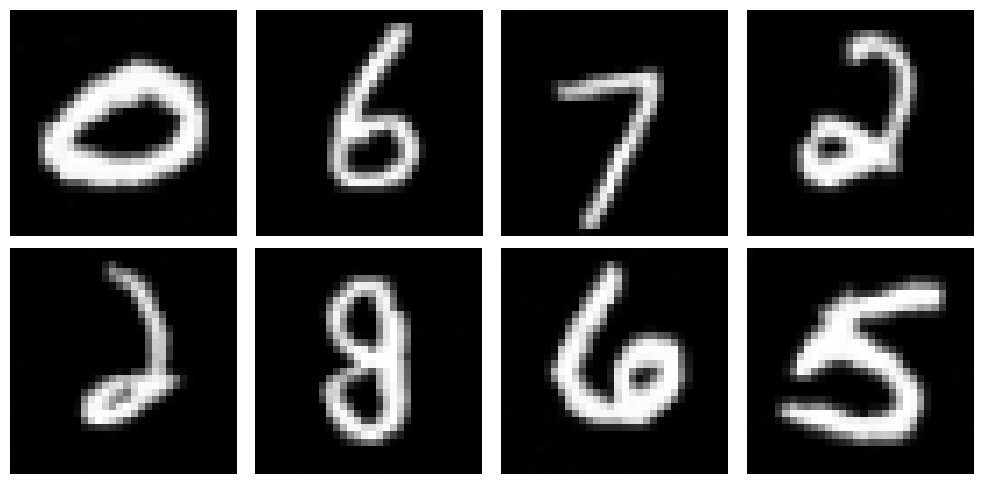

In [23]:
plot_tensor_grid(samples_list[0])